# Movie Recommendation - Mission 1

### Movielense Dataset EDA


EDA(Exploratory Data Analysis)는 데이터셋을 다양한 각도에서 관찰하고 인사이트를 얻을 수 있는 중요한 데이터 분석 과정입니다. 이를 잘 수행하여 데이터의 특징과 분포에 대해 깊은 이해도를 가진다면, 모델의 성능에도 큰 영향을 끼칠 수 있습니다.

본 미션에서는 Movie Recommendation 대회를 위해 제공되는 [movielens](https://grouplens.org/datasets/movielens/) 를 재구성한 대회 데이터셋에 대한 EDA를 진행하고, 학습 데이터에 더불어 영화의 side-information 데이터에 대해 이해하는 시간을 가져보겠습니다!

## 대회 데이터셋 구성
먼저 데이터셋의 구성을 살펴봅니다.

### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

## train/test 데이터셋 알아보기

Pandas를 이용하여 train 데이터를 로드하고 데이터 구성을 알아봅니다. 이어지는 코드를 실행하면 데이터셋의 간략한 정보와 샘플을 확인할 수 있습니다.

train 데이터셋은 *user, item, time* 세개의 column으로 구성된 반면, test 데이터셋은 *user* column과 비어있는 *item* column으로 구성되어 있음을 참고해 주세요. 대회 진행시, 각각의 사용자에게 10개의 영화를 추천하게 됩니다.

각 column은 다음을 나타냅니다.
- *user*: 사용자 id.
- *item*: 영화 id.
- *time*: 사용자가 해당 영화와 interact한 시간. (UNIX시간 - 1970년 1월 1일 0시 0분 0초 UTC(협정 세계시)에서부터 몇 초나 지났는지를 표시 - 의 초 단위)


영화 id는 *directors.tsv, genres.tsv, writers.tsv, years.tsv, titles.tsv*에서도 일관적으로 사용됩니다. 즉, 동일한 영화 id는 side information 데이터셋에서 동일한 영화를 나타냅니다.

이어지는 cell들을 실행해서 직접 관찰해보세요!

- 마지막 sequence의 item만을 예측하는 것이 아니다.
![image](https://user-images.githubusercontent.com/85151359/159682093-98ba9bc8-3360-49b9-8bfa-2c886a024bd5.png)

- 평가지표 

0과 1사이로 normalize된 Recall@10

<img src=https://user-images.githubusercontent.com/85151359/159682628-bd6f02c6-11bb-467e-98f5-14c8ca867e88.png width=500>

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [1]:
# !wget <대회 데이터 URL>
# !tar -xf data.tar.gz

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
import datetime

In [3]:
data_path = '../input/data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [4]:
train_df.info()
train_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
1130414,29735,1089,1174795381
3865524,103196,1200,1146077130
616033,16394,296,1350437854
3102997,82789,7762,1257290255
1935156,51367,5299,1377065092


In [5]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [6]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있습니다.

## 유저 별 interaction의 수 파악
- 비정상적으로 interaction이 많은 유저들이 있다.
- 특정 개수 이상의 interaction을 가진 유저의 경우 임의의 N개만을 학습에 사용하는 것이 좋을 수 있겠다.

iteraction이 가장 많은 유저 20명
user_id , 개수
8405 	 2912
54465 	 1980
24219 	 1842
32514 	 1830
91349 	 1795
131904 	 1762
34576 	 1760
99754 	 1673
31122 	 1644
118754 	 1627
71975 	 1601
113806 	 1590
41283 	 1571
16938 	 1545
54107 	 1536
119048 	 1526
131894 	 1518
62040 	 1518
120575 	 1508
53998 	 1508
iteraction이 가장 적은 유저 20명
user_id , 개수
53188 	 16
68606 	 19
105578 	 22
128756 	 28
11211 	 32
37385 	 34
88996 	 34
10575 	 35
3679 	 37
9581 	 38
96757 	 38
104701 	 38
116859 	 38
122299 	 38
21070 	 39
54309 	 39
62335 	 39
118343 	 39
120197 	 39
132598 	 39

평균: 164.36450892857144개
중앙값: 114.0개
25% percentile: 71.0개
75% percentile: 200.0개


<AxesSubplot:>

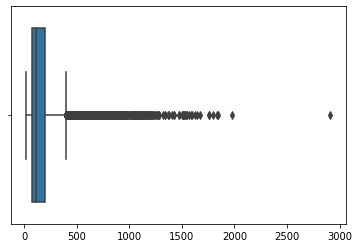

In [7]:
c = Counter(train_df["user"])
tmp = sorted(c.items(), key = lambda x: x[1])
n = 20
print(f"iteraction이 가장 많은 유저 {n}명")
print("user_id , 개수")
for x,y in tmp[-n:][::-1]:
    print(x,"\t",y)
print(f"iteraction이 가장 적은 유저 {n}명")
print("user_id , 개수")
for x,y in tmp[:n]:
    print(x,"\t",y)
print()
tmp2 = list(c.values())
print(f"평균: {np.mean(tmp2)}개")
print(f"중앙값: {np.median(tmp2)}개")
print(f"25% percentile: {np.percentile(tmp2,q=25)}개")
print(f"75% percentile: {np.percentile(tmp2,q=75)}개")
sns.boxplot(x=tmp2)

- 다행히 timestamp만 다른 중복된 interaction은 존재하지 않는다.

In [8]:
tmp = [(x,y) for x,y in zip(train_df["user"], train_df["item"])]
print(len(set(tmp))==len(train_df))

True


- 2005년 4월부터 2015년 3월까지의 데이터가 존재한다.

In [9]:
min_ = datetime.datetime.fromtimestamp(train_df["time"].min()).strftime('%Y-%m-%d %H:%M:%S')
max_ = datetime.datetime.fromtimestamp(train_df["time"].max()).strftime('%Y-%m-%d %H:%M:%S')
print(f"가장 오래된 데이터: {min_}")
print(f"가장 최근 데이터: {max_}")

가장 오래된 데이터: 2005-04-11 11:56:25
가장 최근 데이터: 2015-03-31 05:50:52


In [10]:
def unix_to_date(x):
    return datetime.datetime.fromtimestamp(x).strftime('%Y-%m')
df_month = train_df["time"].apply(unix_to_date)

In [11]:
c = Counter(df_month)

- 월별 interaction의 수를 보면 시간에 따라 줄어드는 경향성을 보인다.
- 별도의 조치는 필요하지 않아 보인다.

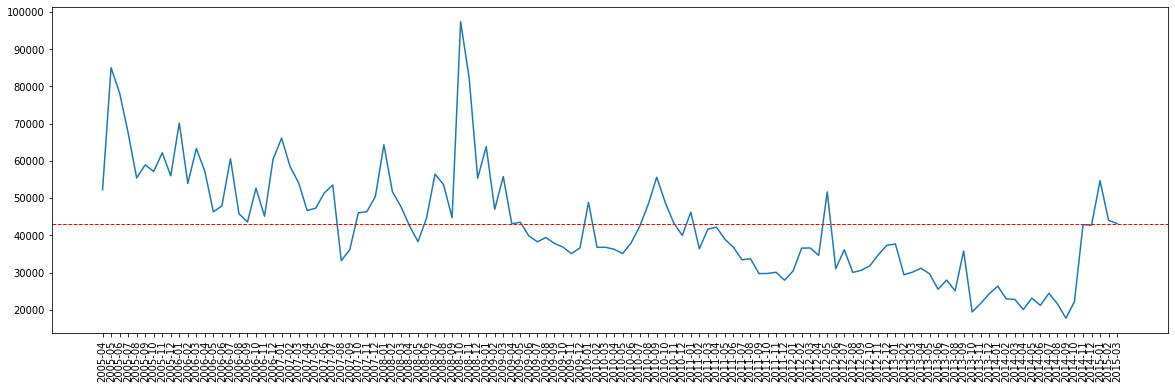

월 평균 interaction 수: 42953.925개


In [12]:
plt.figure(figsize=(20,6))
xx_ = []; yy_ = []
for x,y in sorted(c.items(), key = lambda x:x[0]):
    xx_.append(x)
    yy_.append(y)
sns.lineplot(x = xx_, y = yy_)
plt.xticks(rotation=90)
plt.axhline(y=np.mean(yy_), color='r', linewidth=1, linestyle='--')
plt.show()
print(f"월 평균 interaction 수: {np.mean(yy_)}개")

## Side Information 알아보기

다음은 side information 데이터를 알아봅니다. 일반적으로 추천시스템에서는 side information을 더욱 잘 활용할수록 더 좋은 추천 결과를 얻을 수 있게 됩니다.

주어진 year, writer, title, genre, director 데이터를 불러옵니다. 마찬가지로 각 데이터의 간략한 정보를 확인하고 샘플을 미리 저장해보겠습니다. 샘플된 데이터는 뒤에서도 계속 사용할 예정인 점을 참고해주세요! 그럼 다음 코드를 실행해보겠습니다.

In [13]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

그러면 먼저 *years.tsv* 데이터를 알아보겠습니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *year* : 해당 영화가 개봉한 연도.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

그리고 바로 이어지는 cell을 실행하여 추가적인 통계도 확인합니다. 데이터셋에 한 번 이상 출현하는 영화 작품은 총 6799편이며 평균 개봉 연도는 1992년인 등의 정보를 파악할 수 있습니다.

In [14]:
year_data.info()
year_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
2519,3440,1993
5912,66198,2009
4240,7147,2003
2231,4392,1990
642,1013,1961


In [15]:
print ("Year data shape: ", year_data.shape)
print("Number of unique items in year_df: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())
print ("\nStatistics of year data: ")
year_data['year'].describe()

Year data shape:  (6799, 2)
Number of unique items in year_df:  6799
Number of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

- 1922년 ~ 2014년의 영화들이 존재. 
- right skewed

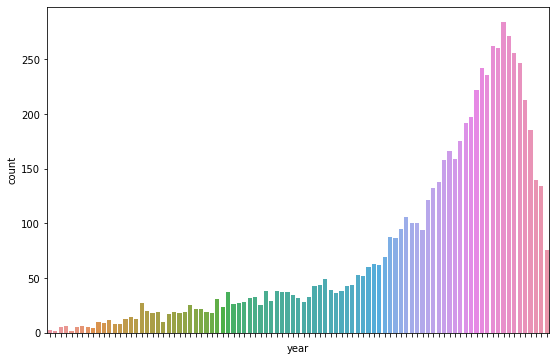

In [16]:
plt.figure(figsize = (9,6))
ax = sns.countplot(x=year_data['year'])
ax.set(xticklabels=[])
plt.show()

다음은 *writers.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *writer* : 영화의 각본가. (익명화)

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [17]:
writer_data.info()
writer_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005


- title 정보가 있는 item이 6807개인 것으로 보아 작가 정보가 누락된 작품들이 있다.

In [18]:
print(len((writer_data["item"].unique())))

5648


- 작가마다 최소 2개에서 많게는 20개가 넘는 작품이 있다.
- 전체 작가 수는 2989명

In [19]:
n = 15
c= Counter(writer_data['writer'])
print(f"다작 상위 {n}명 \n")
print("   작가    |   작품 수")
for x,y in c.most_common(n):
    print(x, "\t", y)

다작 상위 15명 

   작가    |   작품 수
nm0000095 	 47
nm0000636 	 35
nm0000175 	 32
nm0372942 	 30
nm0000108 	 29
nm0000697 	 27
nm0000455 	 26
nm0001220 	 25
nm0000041 	 23
nm0744429 	 21
nm0254645 	 20
nm0462895 	 20
nm0000519 	 19
nm0001279 	 19
nm0004170 	 19


In [20]:
print(f"다작 하위 {n}명 \n")
print("   작가    |   작품 수")
for x,y in sorted(c.items(), key=lambda x: x[1])[:15]:
    print(x, "\t", y)

다작 하위 15명 

   작가    |   작품 수
nm0000036 	 2
nm0000114 	 2
nm0000120 	 2
nm0000160 	 2
nm0000165 	 2
nm0000235 	 2
nm0000354 	 2
nm0000436 	 2
nm0000492 	 2
nm0000532 	 2
nm0000540 	 2
nm0000559 	 2
nm0000583 	 2
nm0000632 	 2
nm0000634 	 2


In [21]:
print( f"전체 감독 수: {len(writer_data['writer'].unique())}명")

전체 감독 수: 2989명


다음은 *titles.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *titles* : 영화 제목.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [22]:
title_data.info()
title_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
287,5377,About a Boy (2002)
4650,3257,"Bodyguard, The (1992)"
3467,2826,"13th Warrior, The (1999)"
4759,2404,Rambo III (1988)
2201,3645,Cleo from 5 to 7 (Cléo de 5 à 7) (1962)


- 제목의 연도 표기와 year_data의 정보는 모두 일치한다. (Big Bang Theory, Fawlty Towers만 표기가 이상함)
- 다만 제목은 있지만 year_data에 item 목록에는 없는 영화들이 존재한다.

In [23]:
print("제목만 있고 year_data에 없는 item 목록")
print(set(title_data["item"].unique()) - set(year_data["item"].unique()))

제목만 있고 year_data에 없는 item 목록
{32898, 119145, 6987, 6988, 7243, 3310, 7065, 8511}


- 아래처럼 제목에서 제작 년도를 찾아 결측치를 채울 수 있다.

In [24]:
import re
cnt = 0
item_year = dict()

for x,y in zip(year_data["item"], year_data["year"]):
    item_year[x] = y

for x, y in zip(title_data["title"], title_data["item"]):
    a = re.compile("\(\d+\)")
    if y not in item_year:
        pass
    try:
        if int(re.findall(a, x)[0][1:-1]) != item_year[y]:
            cnt+=1
    except:
        print(x, y)
print(cnt)

Cabinet of Dr. Caligari, The (Cabinet des Dr. Caligari., Das) (1920) 6987
Kid, The (1921) 3310
Birth of a Nation, The (1915) 7065
Intolerance: Love's Struggle Throughout the Ages (1916) 7243
Immigrant, The (1917) 8511
Broken Blossoms or The Yellow Man and the Girl (1919) 6988
Trip to the Moon, A (Voyage dans la lune, Le) (1902) 32898
Fawlty Towers (1975-1979) 108583
Kingsman: The Secret Service (2015) 119145
Big Bang Theory, The (2007-) 108548
1


다음은 *genres.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *genre* : 영화의 장르.

하나의 영화는 여러 개의 장르를 가질 수 있습니다.
다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [25]:
genre_data.info()
genre_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


- 장르는 title에 존재하는 모든 item에 대해 정보가 있다.
- 하나의 item이 여러 장르를 가질 수 있다.

In [26]:
print(len((genre_data["item"].unique())))
print(set(title_data["item"].unique()) == set(genre_data["item"].unique()))

6807
True


- 장르는 총 18개

In [27]:
genre_data["genre"].unique()

array(['Crime', 'Drama', 'Action', 'Sci-Fi', 'Thriller', 'Comedy',
       'Romance', 'War', 'Adventure', 'Fantasy', 'Horror', 'Mystery',
       'Animation', 'Children', 'Film-Noir', 'Musical', 'Western',
       'Documentary'], dtype=object)

마지막으로 *directors.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *director* : 영화 감독. (익명화)

하나의 영화는 여러 명의 감독을 가질 수 있습니다. 다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [28]:
director_data.info()
director_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


- 감독 정보 역시 작가처럼 누락된 경우가 꽤 많다.

In [29]:
print(len((director_data["item"].unique())))
k = len(set(title_data["item"].unique()) - set(director_data["item"].unique()))
print(f"감독 정보가 없는 작품 수: {k}개")
kk = len(set(director_data["item"].unique()) - set(writer_data["item"].unique()))
print(f"작가 정보는 있지만 감독 정보가 없는 작품 수: {kk}개")
kkk = len(set(writer_data["item"].unique()) - set(director_data["item"].unique()))
print(f"감독 정보는 있지만 작가 정보가 없는 작품 수: {kkk}개")

5503
감독 정보가 없는 작품 수: 1304개
작가 정보는 있지만 감독 정보가 없는 작품 수: 530개
감독 정보는 있지만 작가 정보가 없는 작품 수: 675개


In [30]:
n = 15
c= Counter(director_data['director'])
print(f"다작 상위 {n}명 \n")
print("  감독    |   작품 수")
for x,y in c.most_common(n):
    print(x, "\t", y)

다작 상위 15명 

  감독    |   작품 수
nm0000095 	 44
nm0000033 	 33
nm0000142 	 31
nm0000229 	 29
nm0000217 	 26
nm0001752 	 23
nm0000165 	 20
nm0943758 	 20
nm0000005 	 19
nm0000041 	 19
nm0000631 	 19
nm0000697 	 19
nm0001379 	 19
nm0001348 	 18
nm0001469 	 18


In [31]:
print(f"다작 하위 {n}명 \n")
print("   감독    |   작품 수")
for x,y in sorted(c.items(), key=lambda x: x[1])[:15]:
    print(x, "\t", y)

다작 하위 15명 

   감독    |   작품 수
nm0000045 	 2
nm0000078 	 2
nm0000134 	 2
nm0000169 	 2
nm0000200 	 2
nm0000243 	 2
nm0000345 	 2
nm0000438 	 2
nm0000454 	 2
nm0000540 	 2
nm0000671 	 2
nm0000755 	 2
nm0000770 	 2
nm0000778 	 2
nm0000788 	 2


## 데이터 시각화 해보기
앞에서 주어진 데이터셋을 먼저 간단히 살펴보았습니다. 이제부터는 다수의 파일을 merge하여 시각화하고, 데이터에 대해 좀 더 깊은 이해를 해보겠습니다.

먼저 효율적인 데이터 시각화를 위해, 데이터셋에서 빈도수가 높은 movie, user 데이터의 id를 미리 저장하겠습니다.
train 데이터에서 데이터의 출현 빈도 순으로 *active_user_ids*와 *popular_movie_ids*에 top 10을 각각 저장합니다.

대회 데이터셋에서 빈도수가 높을수록 유명한 영화를 나타내는 것은 아니지만, 편의상 *popular_movie_id* 변수명을 사용하는 점을 당부드립니다.

다음 코드를 실행해주세요.

In [32]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


*active_user_ids*와 *popular_movie_ids*에 각각 빈도가 높은 영화와 사용자 id들을 저장했습니다. 뒤에서도 계속 사용할 예정이니 참고해 주세요.

이제부터는 train 데이터와 side information 데이터를 merge하고, side information 별 user-item 빈도수가 높은 데이터 샘플을 미리 저장합니다. 위에서 저장한 active user id와 popular movie id와 다르게 여기서는 바로 Pandas Dataframe의 형태로 샘플을 저장합니다. 빈도가 가장 높은 10개 side information data가 해당하는 모든 user-item interaction를 저장할 것이므로, 각 side information 데이터 샘플의 크기는 상이합니다.

이어지는 코드 cell들을 실행해보고, 출력된 결과를 충분히 관찰해보시기 바랍니다.

In [33]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

side_df = []
for director in director_id:
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
           user   item        time   director
505699   49645   5445  1197965177  nm0000229
910240   30123   2959  1160390518  nm0000399
1120969  46936   1721  1250934063  nm0000116
1366562  88763  58559  1319140705  nm0634240
4697931  36166   1127  1267484123  nm0000116

shape of the data:  (672019, 4)


In [34]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
            user    item        time     writer
7457127   29122   78499  1398623535  nm0004056
4440549   84158    2115  1334754502  nm0000184
4957760  132195    1089  1308460038  nm0000233
1491757   30043    3114  1137785514  nm0004056
8917502    4222  109487  1416119972  nm0634240

shape of the data:  (651286, 4)


In [35]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]


side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
            user  item        time  \
599017   122871  4993  1230571199   
1081725   97033  5952  1161729699   
810911    74356  2959  1143663257   
109215    15016  2858  1117490990   
866167   127511   356  1358785297   

                                                     title  
599017   Lord of the Rings: The Fellowship of the Ring,...  
1081725      Lord of the Rings: The Two Towers, The (2002)  
810911                                   Fight Club (1999) 

In [36]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

Number of all unique years:  93

top 10 years: 
 Int64Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
            user  item        time  year
2027667   59477  3147  1136804817  1999
4209379  117413  3992  1304423696  2000
2225354   73835    47  1221037345  1995
235494    91536  2571  1220194548  1999
939274     5284   165  1215017504  1995

shape of the data:  (2173226, 4)


여기까지 director, writer, title, year 데이터를 확인해 보았는데요. 이어서 genre 데이터도 관찰해보겠습니다. 데이터셋에서 genre의 수가 총 18개밖에 없으므로 빈도수가 높은 genre를 따로 저장할 필요 없이, train 데이터와의 merge를 바로 진행하겠습니다.

다음 코드를 실행하고 genre 데이터의 형태도 관찰해보세요.

In [37]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
             user   item        time      genre
7702362    18803   2000  1174592099      Crime
9563355    13955   3993  1225385749      Drama
8148631   135620   5679  1349646643   Thriller
13338788   13263  62376  1402797864     Sci-Fi
4027900    83461    380  1231263730  Adventure

shape of the data:  (14126324, 4)


여기까지 오셨으면 side information 데이터의 형태를 충분히 파악하셨을 것으로 생각됩니다! 이제
matplotlib library를 사용하여 샘플한 데이터를 그래프로 시각화해봅니다. 

<function matplotlib.pyplot.show(close=None, block=None)>

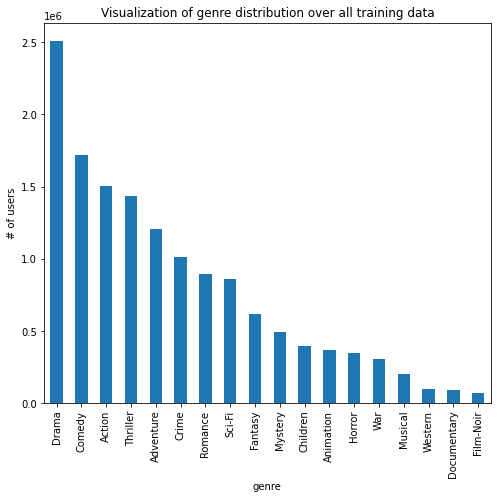

In [38]:
genre_top['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')
plt.show

데이터셋에서 가장 많이 출현하는 장르가 *Drama*, 가장 적게 출현하는 장르가 *Film-Noir*임을 확인할 수 있었습니다.

그러면 전체 training 데이터에서의 genre 분포 뿐만 아니라, genre 데이터 단독의 분포를 출력하면 어떤지 비교해 봅니다. 코드를 실행해주세요.

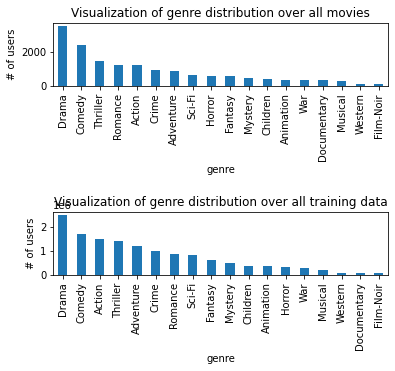

In [39]:
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

두 개의 그래프를 확인하면 거의 비슷해보이지만, 두 분포 사이에 작은 차이가 있음을 확인할 수 있습니다. 가령, *Romance* 장르의 영화가 전체 훈련 데이터에서는 7위를 차지하지만, 모든 6807개의 영화 중에서는 4위를 차지합니다. 이는 *Romance* 장르에 해당하는 영화의 갯수에 비해 실제 사용자들이 시청할 확률이 더 높았다는 것을 뜻합니다.

다음은 사용자 한명이 시청한 영화 리스트를 확인하고, 해당 사용자가 가장 선호하는 장르를 순위별로 차트로 알아보겠습니다. 다음 코드에서는 데이터가 가장 많은 사용자의 id인 `active_user_ids[0]`를 사용하겠습니다.
그럼 코드를 실행해보세요!

- 당연하게도 사람마다 장르 취향은 다르게 나타난다.

<AxesSubplot:>

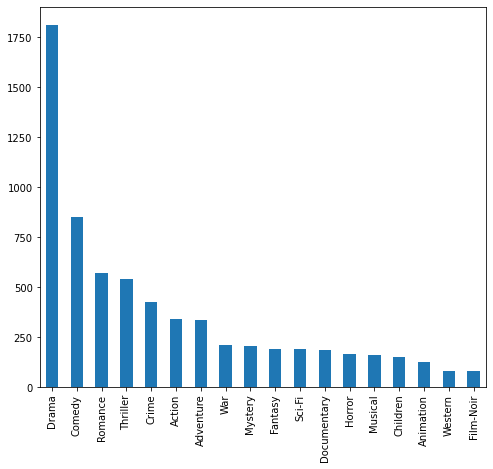

In [40]:
user_id = active_user_ids[0] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

`active_user_ids[0]`에 해당하는 사용자의 시청영화 장르 분포는 전체 데이터의 장르 분포와 크게 차이가 나지 않습니다. 그렇다면 `active_user_ids[1]`에 해당하는 사용자는 어떨까요? 다양한 사용자들의 장르 분포도 한번 비교해 보시기 바랍니다.

<AxesSubplot:>

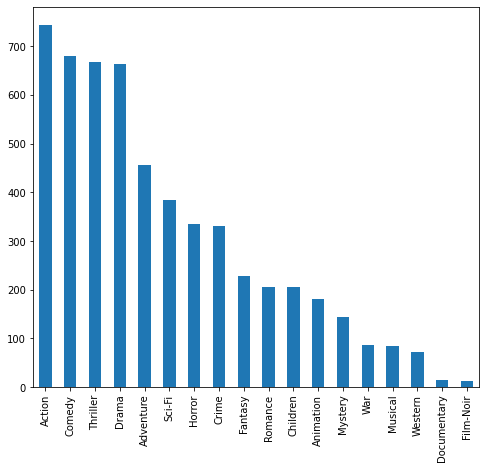

In [103]:
user_id = active_user_ids[1] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

<AxesSubplot:>

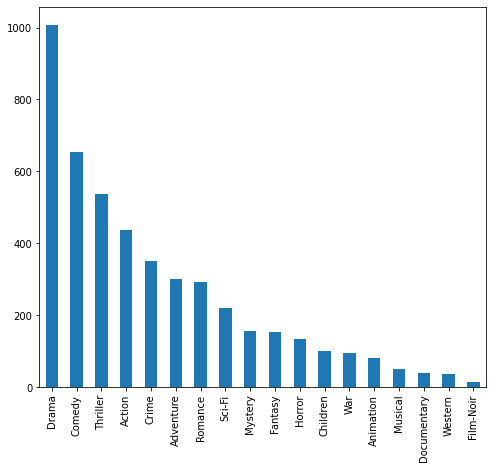

In [104]:
user_id = active_user_ids[2] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

다음은 사용자가 주로 언제 영화를 시청했는지 알아보려고 합니다.
그 전에 먼저 간단히 알고 넘어가면 좋은 내용이 있는데요. train 데이터를 보시면 timestamp column은 유닉스 시간(Unix time)을 초 단위로 표시한 것입니다. 통계를 위해 이것을 우리가 알아볼 수 있는 단위로 변환하는 방법을 알아보겠습니다. 다음 코드를 실행해보세요.

In [ ]:
import time
unix_time = 1230782529 # some random timestamp from dataset
converted_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(unix_time))

print ("initial unix-based timestamp: %s\nconverted time: %s"%(unix_time, converted_time))

파이썬의 time 라이브러리를 사용하여 연-월-일 시간-분-초 단위까지 잘 변환이 되는 것을 확인했습니다. 
하지만 우리 데이터셋의 영화 연도 분포와 task를 고려했을때 시간-분-초 단위는 크게 중요하지 않을 것 같습니다. 일 단위도 빼고, 연-월 단위만 가지고 사용자의 시청 연-월 그래프를 확인해보겠습니다.

즉, 위와 같은 방법으로 timestamp를 변환하여 `active_user_ids[0]`에 해당하는 사용자가 어느 시기에 가장 많은 interaction 활동을 했는지 알아봅니다. 다음 코드를 실행하여 그래프를 확인해봅니다.

In [ ]:
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['time']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column

converted_df['time'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')

해당 사용자는 대략 2007년 전후로 영화 시청을 가장 많이 했고, 시간이 지나면서 시청 기록이 점점 줄어드는 확인할 수 있습니다.

이어서 사용자가 처음으로 또는 마지막으로 영화 시청을 한 시기도 직접 출력해볼 수 있겠습니다. 또, 다른 사용자들의 분포는 얼마나 다를까요?
혹은, 어떤 영화가 어떤 연도에 가장 많이 소비되었을까요?

눈치 채셨을지 모르겠지만, 앞서 저장했던 *popular_movie_id* 변수는 시각화에 사용되지 않았는데요. 선택 과제로 활용해보시기 바랍니다!

## 결론

1. 적당한 임베딩을 통해 side_info(감독, 작가, 연도 등)들을 활용할 수 있을 것 같다.
2. 작가와 감독의 경우 결측치들을 따로 라벨링 해줘야한다. 장르는 멀티핫인코딩으로 쉽게 활용할 수 있지 않을까?
3. 연도의 경우 결측치 8개를 제목으로부터 채울 수 있다.
4. 제목의 경우 너무 얼마 되지 않아서,, 유의미하게 워드 임베딩을 통해 활용할 수 있을지 의문이다.
5. sequential한 예측을 하는 경우 user 별 interaction의 수의 통계치를 max_len과 neg_sample 설정에 잘 활용해야한다.
6. Bert4Rec을 기본적으로 활용하되, static한 정보들을 어떻게 추가로 활용할 수 있을지 고민해봐야한다.